In [ ]:
#| default_exp stonehenge

In [ ]:
#| include: false
from fastcore.all import *

In [ ]:
#| exporti

from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import requests
from PIL import Image

# The Stonehenge Dataset

We use a dataset from the [Stanford NeRF Navigation project](https://mikh3x4.github.io/nerf-navigation/). It consists of 500 images, split into 200 images for training, and then validation and tests sets of 150 images each.

## Loading Images

The code below reads an image into memory:

In [ ]:
#| export
URL = "https://raw.githubusercontent.com/gtbook/robotics/main/stonehenge/"

In [ ]:
#| export
def read_stonehenge_image(path:str, downsampling_factor:int=1):
    """
    Read image from the Stonehenge dataset, and return as a PIL image.

    Returns:
    PIL.Image: Image object representing the image at the specified index.
    """
    # Get stream of image data
    url = f"{URL}/{path}"
    response = requests.get(url, stream=True)
    response.raise_for_status()  # This will raise an error for bad responses

    # Read image from stream
    image = Image.open(response.raw)
    
    # Blend image onto white background
    if downsampling_factor > 1:
        image = image.resize((image.width // downsampling_factor, image.height // downsampling_factor))
    rgb_image = Image.new('RGB', image.size, (255, 255, 255))
    rgb_image.paste(image, mask=image.split()[3])  # 3 is the index of the alpha channel
    return rgb_image


In [ ]:
#| export
def read_training_image(index:int, downsampling_factor:int=1):
    """Read image from the stonehenge dataset, and return as a PIL image."""
    return read_stonehenge_image(f"train/render{index}.png", downsampling_factor)


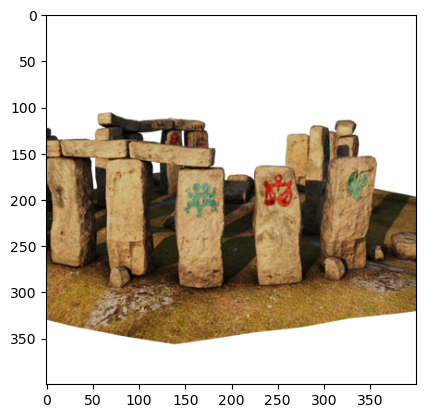

In [ ]:
image = read_training_image(60, downsampling_factor=2)
plt.imshow(image);

## Camera Matrices

A NeRF is trained with a set of *rays*. For a given image, every pixel in the image corresponds to a ray, and the *origin* of the ray is exactly the optical center of the camera. To calculate the *direction* of the ray need two pieces of information for ech image:

- the *intrinsic* calibration of the camera, most importantly the focal length, tells us how to convert pixel coordinates into a direction in the camera coordinate frame.
- the *extrinsic* calibration, position and orientation with which the image was taken, is needed to transform directions in the camera frame into the scene coordinate frame.

For the Stonehenge dataset, all this hard work has been done for us, and/or the images have been simulated with exactly known camera parameters, both intrinsic and extrinsic. The dataset creators provide undistorted images accompanied by a $3 \times 4$ **camera matrix** $M$.

The Stonehenge dataset came with its camera matrices: they were all written in a json file, which we can parse into a python dictionary:

In [ ]:
#| export
def load_json(path):
    """
    Load and parse a JSON file from a relative path.

    Returns:
    dict: Parsed JSON data as a Python dictionary.
    """
    url = f"{URL}/{path}"
    response = requests.get(url)
    response.raise_for_status()  # This will raise an error for bad responses
    return response.json()


In [ ]:
# Open the transforms JSON file and read its content
data = load_json("transforms_train.json")
test_eq(len(data), 4)
test_eq(list(data.keys()), ['Far', 'Near', 'camera_angle_x', 'frames'])

The camera matrix associated with the image below can then be extracted by converting to numpy:

In [ ]:
#| export

def calculate_intrinsics(image_size: tuple, camera_angle_x: float) -> np.ndarray:
    """Calculate the intrinsic matrix given the image size and camera angle."""
    W, H = image_size
    f = W / (2 * np.tan(camera_angle_x/2))
    return np.array([[f, 0, W/2], [0, f, H/2], [0, 0, 1]])

def extract_extrinsics(camera_data: dict, index: int) -> np.ndarray:
    """Extract the extrinsic matrix from the given camera_data."""
    wTc = np.array(camera_data["frames"][index]["transform_matrix"]) # Make sure to use the index parameter
    t = wTc[:3, 3] # translation
    R = wTc[:3, :3] # rotation
    return np.hstack((R.T, -R.T @ t.reshape(-1, 1)))

def extract_camera_matrix(camera_data, index:int, image_size: tuple) -> np.ndarray:
    """Read the 3x4 camera matrix associated with a training image."""
    K = calculate_intrinsics(image_size, camera_data['camera_angle_x'])
    M = extract_extrinsics(camera_data, index)
    return K @ M

In [ ]:
# Testing:
M = extract_camera_matrix(data, 47, (800,800))
test_eq(M.shape, (3, 4))
expected = np.array(
    [
        [1152, 17, 255, -1000],
        [-113, 385, 1111, -1000],
        [0, -1, 1, -2],
    ]
)
test_close(M, expected, eps=1.0)

## Checking Stonehenge Dimensions

We can use a camera matrix to project arbitrary points into the scene. We will use this to project a circle to ascertain the dimensions in which the Stonehenge scene fits.

In [ ]:
# Make a function to load the camera matrix and project a circle into the image:
def project_circle(camera_data, index, image_size, circle):
    """Project the circle into the image."""
    M = extract_camera_matrix(camera_data, index, image_size)
    homogeneous = M @ circle
    return homogeneous[:2] / homogeneous[-1]

In [ ]:
# Create a circle of given radius on the ground plane:
R = 1.5
theta = np.linspace(0, 2*np.pi, 100)
x = R * np.cos(theta)
y = R * np.sin(theta)
z = np.zeros_like(x)
circle = np.vstack((x, y, z, np.ones_like(x)))

# Check its shape, should be 4D homogenous coordinates:
test_eq(circle.shape, (4, 100))

In [ ]:
# Apply it to image 47 check the shape:
circle_47 = project_circle(data, 47, (800, 800), circle)
test_eq(circle_47.shape, (2, 100))

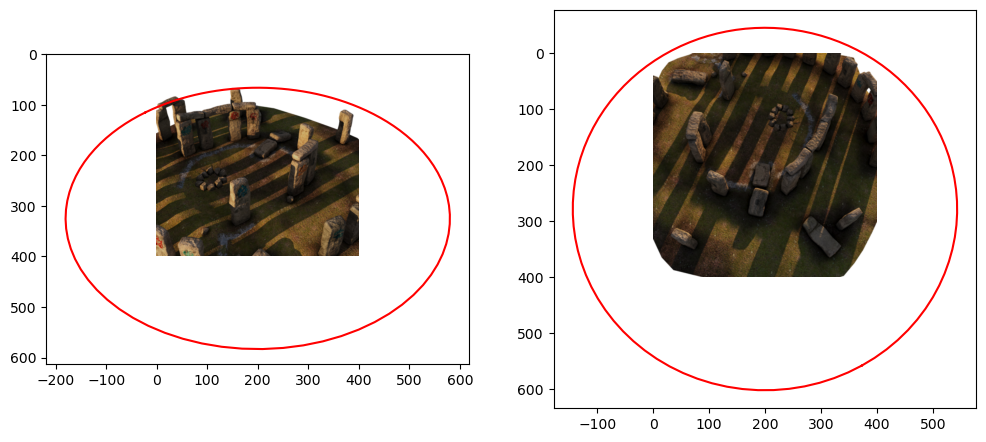

In [ ]:
# Show two images side by side and plot the circles on the image:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
i1, i2 = 70, 140
ax1.imshow(read_training_image(i1, downsampling_factor=2))
ax1.plot(*project_circle(data, i1, (400, 400), circle), color="red")
ax2.imshow(read_training_image(i2, downsampling_factor=2))
ax2.plot(*project_circle(data, i2, (400, 400), circle), color="red");

## Calculating Rays

Recall that a 3D point $P$ can be projected into an image via

$$
\tilde{p} = K R^T (P - t)
$$

where $\tilde{p}$ are *homogeneous* 2D image coordinates. We can re-write this as

$$
\tilde{p} = M\tilde{P}
$$

where $\tilde{P} = \begin{bmatrix}P \\1 \end{bmatrix}$ and the camera matrix $M$ is given by

$$
M = [A|a] = [K R^T | - K R^T t]
$$

That means that if we are *given* the camera matrix $M$ we can always recover the ray origins as 
$$
t = -A^{-1} a
$$

and a random 3D point $P$ on the ray corresponding to $\tilde{p}$ as

$$
P = A^{-1}(\tilde{p} - a)
$$

since $\tilde{p} = AP + a$.

We can then calculate the ray origin and ray direction for any pixel:

In [ ]:
A, a = M[:, :3], M[:, 3]
t = -np.linalg.inv(A) @ a
p_ = np.array([3.5, 2.5, 1]) # middle of a 7x5 image (width x height) in homogeneous coordinates.
P = np.linalg.inv(A) @ (p_ - a)
D = P / np.linalg.norm(P)
test_close(t, np.array([0.54, -1.85, 1.60]), eps=0.1)
test_close(D, np.array([0.14, -0.82, 0.55]), eps=0.1)

In [ ]:
#| export
def calculate_rays(M: np.ndarray, image_size: tuple) -> tuple:
    """ Calculate a batch of rays associated with every pixel in a given image.
        When given size (W, H), returns two tensors of shape (H, W, 3) and (H, W, 3).
    """
    W, H = image_size
    A, a = M[:, :3], M[:, 3]
    inv_A = np.linalg.inv(A)

    # Compute origin and expand to all pixels.
    t = -inv_A @ a
    ones = np.ones((H, W))
    T = np.einsum('i,hw->hwi', t, ones) # creates (H,W,3) batch
    
    # Batch compute directions for all pixels.
    x, y = np.meshgrid(np.linspace(0.5, W-0.5, W), np.linspace(0.5, H-0.5, H), indexing='xy')
    p_ = np.stack([x, y, ones], axis=-1)
    P = - np.einsum('ij,hwj->hwi', inv_A, p_ - a) # batch matrix multiply

    norms = np.linalg.norm(P, axis=-1, keepdims=True)
    D = P / (norms + 1e-8)

    return T, D

Let's try this for a simple 7x5 image (where 7 is width and 5 is height), and check that the batch dimensions are as we expect (width, height, 3), and that for the center pixel they agree with our manual calculation:

In [ ]:
origins, directions = calculate_rays(M, (7, 5))

# Check dimensions:
test_eq(origins.shape, (5, 7, 3))
test_eq(directions.shape, (5, 7, 3))

# Check values for middle pixel, on optical axis:
test_close(origins[2, 3, :], t)
test_close(directions[2, 3, :], -D)

Check that we get the same direction in top-left corner for different resolutions:

In [ ]:
size = 400, 400
M = extract_camera_matrix(data, 10, size)
_, D400 = calculate_rays(M, size)
print(D400[0,0,:])

size = 800, 800
M = extract_camera_matrix(data, 10, size)
_, D800 = calculate_rays(M, size)
print(D800[0,0,:])

test_close(D400[0,0,:], D800[0,0,:], eps=1e-3)

size = 200, 200
M = extract_camera_matrix(data, 10, size)
_, D200 = calculate_rays(M, size)
print(D200[0,0,:])

test_close(D400[0,0,:], D200[0,0,:], eps=1e-3)

[-0.57143088  0.80036988 -0.18131408]
[-0.57134447  0.80046027 -0.18118731]
[-0.57160367  0.800189   -0.18156763]


Below we cycle through 20 of the 200 training images, showing 64 rows for each.

In [ ]:
fig = go.Figure()
for i in range(0, 199, 10):
    M = extract_camera_matrix(data, i, (image.size))
    origins, directions = calculate_rays(M, (image.size))
    T = origins[::100,::100,:].reshape(-1, 3)
    D = directions[::100,::100,:].reshape(-1, 3)

    # Adding line segments for each ray
    for start, end in zip(T, T + D):
        fig.add_trace(go.Scatter3d(x=[start[0], end[0]],
                                y=[start[1], end[1]],
                                z=[start[2], end[2]],
                                mode='lines',
                                line=dict(color='red')))

fig.update_layout(showlegend=False)
fig.show()

And here we show samples for one ray from each of those 20 cameras, with the rendering volume shown as well:

In [ ]:
t_values = np.linspace(data["Near"], data["Far"], 64)

def sample_along_ray(origins, directions):
    return origins[..., None, :] + t_values[:, None] * directions[..., None, :]

fig = go.Figure()
W, H = image.size
for i in range(0, 199):
    M = extract_camera_matrix(data, i, image.size)
    origins, directions = calculate_rays(M, image.size)
    i = np.random.randint(0, W)
    j = np.random.randint(0, H)
    T = origins[i, j, :]
    D = directions[i, j, :]
    samples = sample_along_ray(T, D)

    # Adding line segments for each ray
    fig.add_trace(
        go.Scatter3d(
            x=samples[:, 0],
            y=samples[:, 1],
            z=samples[:, 2],
            mode="lines",
            line=dict(color="red"),
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[T[0].item()],
            y=[T[1].item()],
            z=[T[2].item()],
            mode="markers",
            marker=dict(color="red", size=2),
        )
    )

# add a cuboid from -1 to 1 in x and y, and 0 to 0.5 in z:
fig.add_trace(
    go.Mesh3d(
        x=[-1, 1, 1, -1, -1, 1, 1, -1],
        y=[-1, -1, 1, 1, -1, -1, 1, 1],
        z=[-0.5, -0.5, -0.5, -0.5, 0.5, 0.5, 0.5, 0.5],
        i=[0, 0, 4, 4],
        j=[1, 2, 5, 6],
        k=[2, 3, 6, 7],
        opacity=0.5,
        color="lightblue",
    )
)

fig.update_layout(showlegend=False, margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Ray-centric Dataset

The code below encodes all training images into rays:

In [ ]:
#| export
def create_rays(camera_data, M = 199, downsampling_factor = 1):
    """Create rays for the training images.
    Args:
        camera_data: Dictionary containing the camera data.
        M: Number of training images to use.
        downsampling_factor: Downsampling factor to apply to the images.
    Returns:
        x_samples: Tensor of shape (M, H, W, 6) containing the origins and directions of the rays.
        y_samples: Tensor of shape (M, H, W, 3) containing the color data for each pixel.
    """
    W, H = read_training_image(0, downsampling_factor).size

    # Pre-allocate tensors
    x_samples = np.empty((M, H, W, 6), dtype=np.float32)
    y_samples = np.empty((M, H, W, 3), dtype=np.float32)

    for i in range(M):
        image = read_training_image(i, downsampling_factor)  # Get the i-th image

        M = extract_camera_matrix(camera_data, i, image.size)
        origins, directions = calculate_rays(M, image.size)
        origins = origins.astype(np.float32)
        directions = directions.astype(np.float32)

        # Combine data for x_samples
        x_samples[i] = np.concatenate((origins, directions), axis=-1)

        # Use the color data for y_samples
        y_samples[i] = np.array(image, dtype=np.float32)/255.0
    
    # Convert to float32 and return:
    return x_samples, y_samples

In [ ]:
x_samples, y_samples = create_rays(data, 2, downsampling_factor=4)
# Check shapes:
test_eq(x_samples.shape, (2, 200, 200, 6))
test_eq(y_samples.shape, (2, 200, 200, 3))
# Check type:
test_eq(x_samples.dtype, np.float32)
test_eq(y_samples.dtype, np.float32)

In [ ]:
# Uncomment the following line to save the file:
# np.savez_compressed('training_rays.npz', x=x_samples, y=y_samples)

# x_samples, y_samples = create_rays(100, downsampling_factor=4)
# np.savez_compressed('training_rays-100-4.npz', x=x_samples, y=y_samples)

In [ ]:
#| export
def load_npz_from_url(url):
    """
    Loads a .npz file from the given URL and returns the contained arrays as a tuple.

    Parameters:
    url (str): URL of the .npz file.

    Returns:
    tuple: A tuple containing the loaded numpy arrays, or None if the request fails.
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        response.raise_for_status()

        # Open the content of the response as a file-like object
        file_like_object = BytesIO(response.content)

        # Load the .npz file and return the contained arrays
        with np.load(file_like_object) as data:
            return tuple(data[key] for key in data)
    
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None

In [ ]:
# Example usage to download the full Zenodo version, takes 5m!
# url = 'https://zenodo.org/records/10443662/files/training_rays.npz'
# loaded_arrays = load_npz_from_url(url)
# if loaded_arrays is not None:
#     xs, ys = loaded_arrays

# # check that they have the right shape:
# test_eq(xs.shape, (199, 800, 800, 6))
# test_eq(ys.shape, (199, 800, 800, 3))

# # check that they are float32:
# test_eq(xs.dtype, np.float32)
# test_eq(ys.dtype, np.float32)

In [ ]:
#| export
def download_rays(M=100, downsampling_factor=4):
    url = f'{URL}/training_rays-{M}-{downsampling_factor}.npz'
    return load_npz_from_url(url)

In [ ]:
# Example usage to download the downs-sampled github version, 10-12 seconds
xs, ys = download_rays()

# check that they have the right shape:
test_eq(xs.shape, (100, 200, 200, 6))
test_eq(ys.shape, (100, 200, 200, 3))

# check that they are float32:
test_eq(xs.dtype, np.float32)
test_eq(ys.dtype, np.float32)